In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem

# DrugBank data

In [2]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]
df.head()

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,<rdkit.Chem.rdchem.Mol object at 0x000001F7E24...
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,<rdkit.Chem.rdchem.Mol object at 0x000001F7E24...
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,<rdkit.Chem.rdchem.Mol object at 0x000001F7E24...
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,<rdkit.Chem.rdchem.Mol object at 0x000001F7E24...
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,<rdkit.Chem.rdchem.Mol object at 0x000001F7E24...


In [3]:
drug = Chem.SDMolSupplier('drugbank.sdf')

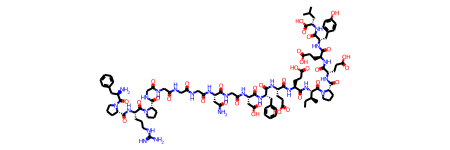

In [4]:
drug[0]

In [5]:
drug[0].GetProp("SMILES")

'CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O'

In [6]:
finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in df.mol] #do vzdálenosti 2
df['finger'] = finger

In [7]:
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 

In [8]:
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 

In [9]:
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])

In [10]:
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()

In [11]:
drug_finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in drug_df.mol]

In [12]:
drug_df['finger'] = drug_finger

In [13]:
similar = []
for j in range(len(drug_df)):
    for i in range(len(df)):
        res = DataStructs.FingerprintSimilarity(df.finger[i], drug_finger[j])
        if res > 0.7:
            similar.append((df.cmpd_chembl_id[i], drug_df.id[j]))

In [14]:
similar # vsechny 

[('CHEMBL3968843', 'DB00317'),
 ('CHEMBL3759754', 'DB00317'),
 ('CHEMBL434311', 'DB00317'),
 ('CHEMBL25610', 'DB00317'),
 ('CHEMBL3920551', 'DB00317'),
 ('CHEMBL939', 'DB00317'),
 ('CHEMBL169797', 'DB00317'),
 ('CHEMBL3957025', 'DB00317'),
 ('CHEMBL24137', 'DB00317'),
 ('CHEMBL3929448', 'DB00317'),
 ('CHEMBL941', 'DB00619'),
 ('CHEMBL1421', 'DB01254'),
 ('CHEMBL306380', 'DB01809'),
 ('CHEMBL50', 'DB01852'),
 ('CHEMBL281948', 'DB02152'),
 ('CHEMBL94678', 'DB02152'),
 ('CHEMBL416056', 'DB02152'),
 ('CHEMBL50', 'DB02375'),
 ('CHEMBL233209', 'DB02491'),
 ('CHEMBL233208', 'DB02491'),
 ('CHEMBL231800', 'DB02491'),
 ('CHEMBL392306', 'DB02491'),
 ('CHEMBL169473', 'DB02984'),
 ('CHEMBL94191', 'DB02984'),
 ('CHEMBL29197', 'DB02984'),
 ('CHEMBL3220401', 'DB02984'),
 ('CHEMBL103667', 'DB03044'),
 ('CHEMBL169473', 'DB03365'),
 ('CHEMBL94191', 'DB03365'),
 ('CHEMBL405130', 'DB03365'),
 ('CHEMBL3219509', 'DB03365'),
 ('CHEMBL29197', 'DB03365'),
 ('CHEMBL3220401', 'DB03365'),
 ('CHEMBL3774563', 'DB033

In [15]:
len(similar)

172

## Deskriptory DrugBank vs VEGF

In [16]:
TPSA = [Descriptors.TPSA(i) for i in df['mol']]
logP = [Descriptors.MolLogP(i) for i in df['mol']]
TPSA_drug = [Descriptors.TPSA(i) for i in drug_df.mol]
logP_drug = [Descriptors.MolLogP(i) for i in drug_df.mol]

In [18]:
l = logP + logP_drug
t = TPSA + TPSA_drug
s = 6715*['VEGF']+ len(logP_drug)*['drug']

In [19]:
data = {'TPSA': t,
        'logP': l,
        'source': s}
d = pd.DataFrame(data, columns = ['TPSA', 'logP','source'])

<AxesSubplot:xlabel='logP', ylabel='TPSA'>

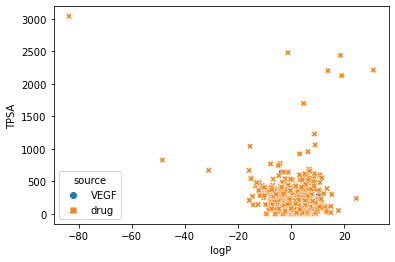

In [20]:
sns.scatterplot(data = d, x='logP', y='TPSA',  hue="source", style = 'source')

In [23]:
drug_df.loc[drug_df.id == 'DB07145']['mol']

5019    <rdkit.Chem.rdchem.Mol object at 0x000001F7F05...
Name: mol, dtype: object

In [42]:
similar_drug = set()
all_similar_drug = []

In [43]:
for i in range(len(similar)):
    similar_drug.add(similar[i][1])
    all_similar_drug.append(similar[i][1])

In [31]:
len(similar_drug)

46

In [35]:
df_hit = drug_df.loc[drug_df.id.isin(similar_drug)]

In [38]:
df_hit.head()

,id,inchi,mol,finger
207,DB00317,InChI=1S/C22H24ClFN4O3/c1-29-20-13-19-16(12-21...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
504,DB00619,InChI=1S/C29H31N7O/c1-21-5-10-25(18-27(21)34-2...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1129,DB01254,InChI=1S/C22H26ClN7O2S/c1-14-4-3-5-16(23)20(14...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1574,DB01809,InChI=1S/C16H19N5/c1-10-5-7-11(8-6-10)13-12-14...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1615,DB01852,InChI=1S/C15H10O6/c16-8-3-1-7(2-4-8)15-14(20)1...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


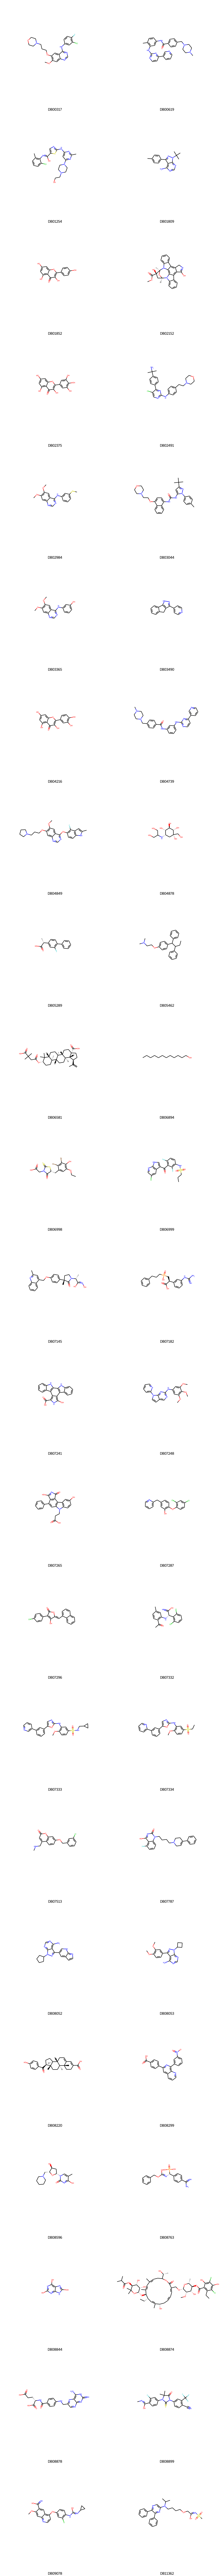

In [39]:
# DrugBank struktury ktere jsou podobne nekterym strukturam v VEGF datasetu
# ktery molekuly z drugbank jsou podobne tem našem
index = df_hit.index
Draw.MolsToGridImage([drug_df.mol[index[i]] for i in range(0,len(df_hit))], molsPerRow=2, subImgSize=(500,500),
                     legends=["{}".format(sim) for sim in df_hit.id])

In [45]:
len(all_similar_drug)

172

In [46]:
data = {'id': all_similar_drug}
df_similar = pd.DataFrame(data, columns = ['id'])

In [47]:
df_similar['id'].value_counts()

DB07333    20
DB04878    15
DB08763    14
DB05289    14
DB00317    10
DB07334    10
DB08053     7
DB07145     7
DB03365     7
DB08052     6
DB07248     6
DB11362     5
DB02491     4
DB02984     4
DB08596     3
DB02152     3
DB07296     3
DB08299     3
DB06581     3
DB07332     2
DB01254     1
DB08844     1
DB08874     1
DB08878     1
DB08220     1
DB08899     1
DB01809     1
DB01852     1
DB09078     1
DB07787     1
DB07513     1
DB04216     1
DB02375     1
DB04739     1
DB07287     1
DB07265     1
DB07241     1
DB00619     1
DB06999     1
DB06998     1
DB06894     1
DB05462     1
DB03044     1
DB03490     1
DB04849     1
DB07182     1
Name: id, dtype: int64

In [49]:
drug_df.loc[drug_df.id == 'DB07333']['mol']

5205    <rdkit.Chem.rdchem.Mol object at 0x000001F7F05...
Name: mol, dtype: object

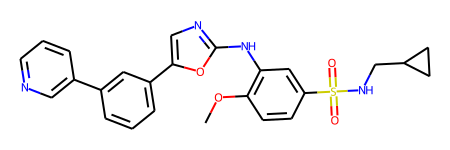

In [50]:
drug_df.mol[5205]